In [79]:
import os
import torch
import sys
os.chdir('/CLIP-Driven-Universal-Model')
if '/CLIP-Driven-Universal-Model' not in sys.path:
    sys.path.append('/CLIP-Driven-Universal-Model')
from utils.utils import get_key, dice_score, TEMPLATE, ORGAN_NAME, NUM_CLASS


In [2]:
path = '/data/clip/result/unet/prediction/01_Multi-Atlas_Labeling/label/label0010.pt'
result =torch.load(path)

In [3]:
result.keys()

dict_keys(['preds', 'labels', 'xs', 'weights', 'biases', 'coords'])

In [15]:
# check that all the keys in result have same length
length = len(result['preds'])
for key in result.keys():
    assert len(result[key]) == length
print(result['preds'][0].shape)
print(result['labels'][0].shape)
print(result['xs'][0][0][-1].shape)
print(result['weights'][0][0][-1].shape)
print(result['biases'][0][0][-1].shape)



torch.Size([1, 32, 96, 96, 96])
torch.Size([1, 31, 96, 96, 96])
torch.Size([32, 8, 96, 96, 96])
torch.Size([32, 8, 1, 1, 1])
torch.Size([32])


In [77]:
# mapping all the preds to the label, any non-zero value in the label is considered as positive points, we filter out 
# the pred have shape [32,8,96,96,96], labels have shape [1, 32,96,96,96] we scan all the organs and get the positive points
device = "cuda:0"
xs = result['xs'][0][0][-1].squeeze(1)[organs, :, :, :]
weights = result['weights'][0][0][-1].squeeze()[organs, :]
biases = result['biases'][0][0][-1][organs]
labels = result['labels'][0].squeeze(0)[organs, :, :, :]
print(xs.shape)
print(weights.shape)
print(biases.shape)
print(labels.shape)
xs.to(device)
weights.to(device)
biases.to(device)
labels.to(device)

# get the positive points
# creat default dict to store the results


    



torch.Size([14, 8, 96, 96, 96])
torch.Size([14, 8])
torch.Size([14])
torch.Size([14, 96, 96, 96])


tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         ...,

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 

In [122]:
import os
import torch
import sys
os.chdir('/CLIP-Driven-Universal-Model')
if '/CLIP-Driven-Universal-Model' not in sys.path:
    sys.path.append('/CLIP-Driven-Universal-Model')
from utils.utils import get_key, dice_score, TEMPLATE, ORGAN_NAME, NUM_CLASS
data_dir = '/data/clip/result/unet/prediction'
# only list the files 
def list_files(data_dir):
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.pt'):
                path = os.path.join(root, file)
                name = path[len(data_dir)+1:]
                yield os.path.join(root, file),name
img_name = '01_Multi-Atlas_Labeling/label/label0010.pt'
# def get_organs(img_name):
#     return TEMPLATE[get_key(img_name)]

def update_distance_centroids_to_weight(img_name,result, distance_centroids_to_weight, counts_centroids_to_weight,device):
    organs = TEMPLATE[get_key(img_name)]
    for i in range(len(result['labels'])):
        xs = result['xs'][i][0][-1].squeeze(1)[organs, :, :, :]
        weights = result['weights'][i][0][-1].squeeze()[organs, :]
        biases = result['biases'][i][0][-1][organs]
        labels = result['labels'][i].squeeze(0)[organs, :, :, :]
        xs = xs.to(device)
        weights = weights.to(device)
        biases = biases.to(device)
        labels = labels.to(device)
        positive_points_by_organs = []
        for index in range(len(labels)):
            mask = labels[index].bool()
            filtered_tensor = xs[index][:,mask]
            if filtered_tensor.shape[0] == 0:
                continue
            # centroid = torch.mean(filtered_tensor, dim=0)
            # get distance from weight to centroids
            # distance = torch.norm(weights[index] - centroid, dim=0)
            positive_points_by_organs.append(filtered_tensor)
        centroids = []
        for positive_points_by_organ in positive_points_by_organs:
            # print(positive_points_by_organ.shape)
            if positive_points_by_organ.shape[1] <= 30:
                
                centroids.append(None)
            else:
                centroid = torch.mean(positive_points_by_organ, dim=1).to(device)
                centroids.append(centroid)
        # count = 0
        # for i in range(len(centroids)):
        #     if centroids[i] is not None:
        #         count += 1
        # print(count)
        for i in range(len(centroids)):
            if centroids[i] is None:
                continue
            for j in range(len(centroids)):
                if centroids[j] is not None:
                    
                    distance_centroids_to_weight[organs[i]][organs[j]] += torch.norm(centroids[i] - weights[j])
                    counts_centroids_to_weight[organs[i]][organs[j]] += 1

distance_centroids_to_weight = [[0 for _ in range(NUM_CLASS)] for _ in range(NUM_CLASS)]
counts_centroids_to_weight = [[0 for _ in range(NUM_CLASS)] for _ in range(NUM_CLASS)]
device = "cuda:0"

for path, img_name in list_files(data_dir):
    result = torch.load(path)
    update_distance_centroids_to_weight(img_name,result, distance_centroids_to_weight, counts_centroids_to_weight,device)
    # store distance_centroids_to_weight and counts_centroids_to_weight
    torch.save({'distance_centroids_to_weight': distance_centroids_to_weight, 'counts_centroids_to_weight': counts_centroids_to_weight}, '/data/clip/result/unet/distance_centroids_to_weight.pt')


KeyboardInterrupt: 

In [4]:
# now get the file and draw graph
import torch
import matplotlib.pyplot as plt
import numpy as np
data = torch.load('/data/clip/result/unet/distance_centroids_to_weight.pt')
data
count = 0
for item in data['distance_centroids_to_weight']:
    for i in item:
        if i != 0:

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
tensor(8.0406, device='cuda:0')
tensor(4.1274, device='cuda:0')
tensor(1.6008, device='cuda:0')
tensor(1.2344, device='cuda:0')
tensor(6.1323, device='cuda:0')
tensor(4.3478, device='cuda:0')
tensor(2.4513, device='cuda:0')
tensor(3.9318, device='cuda:0')
tensor(3.3826, device='cuda:0')
tensor(3.4632, device='cuda:0')
tensor(4.6350, device='cuda:0')
tensor(1.1873, device='cuda:0')
tensor(3.3146, device='cuda:0')
tensor(8.3080, device='cuda:0')
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
tensor(4.0224, device='cuda:0')
tensor(15.9323, device='cuda:0')
tensor(0.8032, device='cuda:0')
tensor(2.0433, device='cuda:0')
tensor(4.5748, device='cuda:0')
tensor(9.0925, device='cuda:0')
tensor(2.4374, device='cuda:0')
tensor(2.1804, device='cuda:0')
tensor(4.6486, device='cuda:0')
tensor(7.6689, device='cuda:0')
tensor(2.3301, device='cuda:0')
tensor(2.3494, device='cuda:0')
tensor(4.1183, device='cuda:0')
tensor(16.1769, device='cuda:0')


In [13]:
count = 0
non_count = 0
for item in data['distance_centroids_to_weight']:
    for i in item:
        if i != 0:
            count += 1
        else:
            non_count += 1
# I have a list of a list of number, convert them to a tensor

distance_centroids_to_weight = torch.tensor(data['distance_centroids_to_weight'])
counts_centroids_to_weight = torch.tensor(data['counts_centroids_to_weight'])
d = distance_centroids_to_weight / counts_centroids_to_weight

In [15]:
# check and remove row with all 0, and columns with all zero on distance_centroids_to_weight

# remove row with all 0
d = d[~torch.all(d == 0, dim=1)]
# remove column with all 0
d = d[:, ~torch.all(d == 0, dim=0)]
d.shape

torch.Size([32, 32])

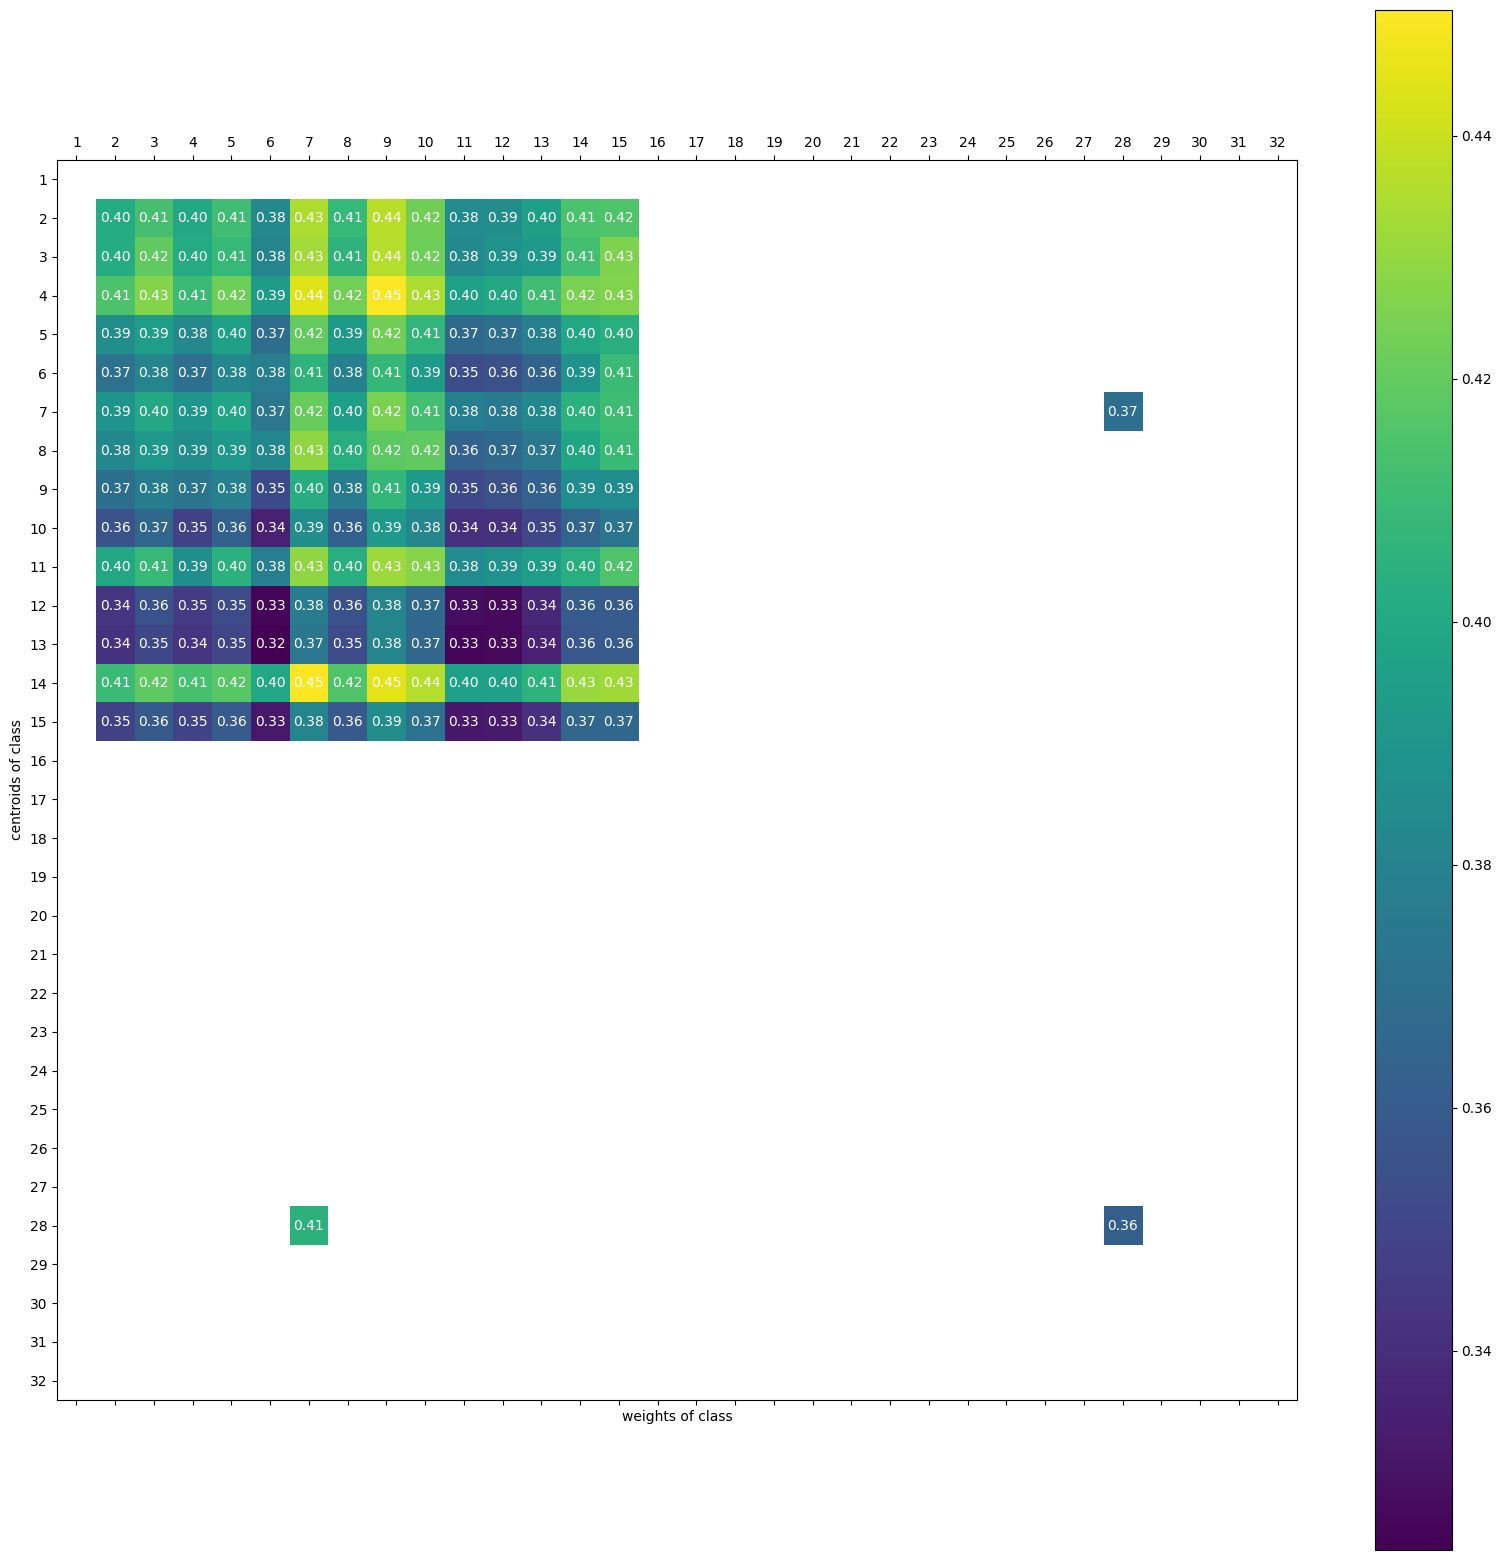

In [33]:
# draw heat map with d, that has number in it, and make it much bigger, have some number inside
# annotate row as centroids, column as weights
def create_heatmap(data):
    fig, ax = plt.subplots(figsize=(20, 20))
    # Create the heatmap
    cax = ax.matshow(data, cmap='viridis')

    # Add a colorbar
    plt.colorbar(cax)

    # Loop over data dimensions and create text annotations.
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = ax.text(j, i, f'{data[i, j]:.2f}',
                           ha="center", va="center", color="w")

    # Set x and y axis labels
    ax.set_xlabel("weights of class")
    ax.set_ylabel("centroids of class")
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(np.arange(1, data.shape[1] + 1))
    ax.set_yticklabels(np.arange(1, data.shape[0] + 1))

    plt.show()
create_heatmap(d)
# check if the main diagonal is 0 is difference from the rest of the matrix, using t-test


In [31]:
import scipy.stats as stats
from scipy.stats import ttest_ind

# get the main diagonal
data_test = d[:15, :15]
data_test = data_test.numpy()
def test_diagonal_difference(matrix):
    # Extract diagonal values
    diagonal_values = np.diag(matrix)
    
    # Extract off-diagonal values
    off_diagonal_values = matrix[~np.eye(matrix.shape[0], dtype=bool)]
    # remove all nan
    diagonal_values = diagonal_values[~np.isnan(diagonal_values)]
    off_diagonal_values = off_diagonal_values[~np.isnan(off_diagonal_values)]
    # Perform t-test
    t_stat, p_value = ttest_ind(diagonal_values, off_diagonal_values)
    
    return t_stat, p_value
test_diagonal_difference(data_test)

(0.42116212772477357, 0.6741029277173161)

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan, 0.4020322 , 0.41274396, 0.40018752, 0.41146764,
        0.38326883, 0.43477672, 0.4085537 , 0.4368693 , 0.42282087,
        0.3848008 , 0.38625368, 0.3957607 , 0.41431978, 0.4154017 ],
       [       nan, 0.40224224, 0.4192715 , 0.40158153, 0.40865073,
        0.38123298, 0.43297514, 0.40624142, 0.43608922, 0.422602  ,
        0.38344353, 0.3883536 , 0.39157084, 0.41182512, 0.42570832],
       [       nan, 0.41475087, 0.42668766, 0.41013792, 0.42251918,
        0.39391547, 0.444312  , 0.42320573, 0.45035976, 0.4346064 ,
        0.39617985, 0.39998037, 0.41140634, 0.4249505 , 0.42649838],
       [       nan, 0.38613412, 0.3944239 , 0.38317326, 0.3961036 ,
        0.36933663, 0.41984567, 0.3928689 , 0.42272842, 0.40725142,
        0.3673872 , 0.37036237, 0.3790228 , 

In [121]:
for file_path,file_name in list_files(data_dir):
    print(file_path)
    print(file_name)

/data/clip/result/unet/prediction/01_Multi-Atlas_Labeling/label/label0077.pt
01_Multi-Atlas_Labeling/label/label0077.pt
/data/clip/result/unet/prediction/01_Multi-Atlas_Labeling/label/label0036.pt
01_Multi-Atlas_Labeling/label/label0036.pt
/data/clip/result/unet/prediction/01_Multi-Atlas_Labeling/label/label0010.pt
01_Multi-Atlas_Labeling/label/label0010.pt
/data/clip/result/unet/prediction/01_Multi-Atlas_Labeling/label/label0066.pt
01_Multi-Atlas_Labeling/label/label0066.pt
/data/clip/result/unet/prediction/04_LiTS/label/liver_98.pt
04_LiTS/label/liver_98.pt
/data/clip/result/unet/prediction/04_LiTS/label/liver_43.pt
04_LiTS/label/liver_43.pt
/data/clip/result/unet/prediction/04_LiTS/label/liver_121.pt
04_LiTS/label/liver_121.pt
/data/clip/result/unet/prediction/04_LiTS/label/liver_124.pt
04_LiTS/label/liver_124.pt
/data/clip/result/unet/prediction/04_LiTS/label/liver_61.pt
04_LiTS/label/liver_61.pt
/data/clip/result/unet/prediction/04_LiTS/label/liver_37.pt
04_LiTS/label/liver_37.pt


In [110]:
print(weights[j].shape)
centroids[i].shape
torch.norm(centroids[i] - weights[j])


torch.Size([8])


tensor(0.3733, device='cuda:0')

In [113]:
for i in range(NUM_CLASS):
    print(distance_centroids_to_weight[i][i])

0
tensor(4.8309, device='cuda:0')
tensor(4.9204, device='cuda:0')
tensor(1.2362, device='cuda:0')
tensor(0.7886, device='cuda:0')
tensor(9.0945, device='cuda:0')
tensor(8.4535, device='cuda:0')
tensor(2.0777, device='cuda:0')
tensor(2.0433, device='cuda:0')
tensor(5.3774, device='cuda:0')
tensor(4.6255, device='cuda:0')
tensor(2.6207, device='cuda:0')
tensor(1.3390, device='cuda:0')
tensor(2.5692, device='cuda:0')
tensor(17.6218, device='cuda:0')
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [114]:
for i in range(NUM_CLASS):
    for j in range(NUM_CLASS):
        if i != j and distance_centroids_to_weight[i][j] != 0:
            print(i,j, distance_centroids_to_weight[i][j]/counts_centroids_to_weight[i][j])

1 2 tensor(0.4132, device='cuda:0')
1 3 tensor(0.4012, device='cuda:0')
1 4 tensor(0.4114, device='cuda:0')
1 5 tensor(0.3840, device='cuda:0')
1 6 tensor(0.4350, device='cuda:0')
1 7 tensor(0.4094, device='cuda:0')
1 8 tensor(0.4374, device='cuda:0')
1 9 tensor(0.4231, device='cuda:0')
1 10 tensor(0.3852, device='cuda:0')
1 11 tensor(0.3863, device='cuda:0')
1 12 tensor(0.3950, device='cuda:0')
1 13 tensor(0.4154, device='cuda:0')
1 14 tensor(0.4158, device='cuda:0')
2 1 tensor(0.4030, device='cuda:0')
2 3 tensor(0.4031, device='cuda:0')
2 4 tensor(0.4102, device='cuda:0')
2 5 tensor(0.3818, device='cuda:0')
2 6 tensor(0.4326, device='cuda:0')
2 7 tensor(0.4074, device='cuda:0')
2 8 tensor(0.4372, device='cuda:0')
2 9 tensor(0.4231, device='cuda:0')
2 10 tensor(0.3834, device='cuda:0')
2 11 tensor(0.3882, device='cuda:0')
2 12 tensor(0.3909, device='cuda:0')
2 13 tensor(0.4149, device='cuda:0')
2 14 tensor(0.4154, device='cuda:0')
3 1 tensor(0.4148, device='cuda:0')
3 2 tensor(0.4262,

In [66]:
for i in range(len(filtered_tensor)):
    print(filtered_tensor[i].shape)
    

torch.Size([0])
torch.Size([0])
torch.Size([0])
torch.Size([0])
torch.Size([0])
torch.Size([0])
torch.Size([0])
torch.Size([0])


In [69]:
a = torch.rand(2,8)

In [71]:
torch.mean(a, dim=0).shape

torch.Size([8])

In [13]:
import torch

# Example 5D tensor (Batch, Channels, Depth, Height, Width)
tensor = torch.randn(14, 8, 96, 96, 96)

# Example 4D label tensor (Batch, Depth, Height, Width)
labels = torch.randint(0, 2, (14, 96, 96, 96), dtype=torch.bool)

# Initialize a list to store the filtered points
filtered_points = []

# Iterate through the batch
for batch_index in range(tensor.shape[0]):
    # Get the mask for the current batch
    mask = labels[batch_index]
    print(mask.shape)
    # Filter the tensor for the current batch using the mask
    filtered_tensor = tensor[batch_index][:, mask]
    
    # Append the filtered points for this batch to the list
    filtered_points.append(filtered_tensor)

# Convert the list to a tensor if necessary
for item in filtered_points:
    print(item.shape)
print(len(filtered_points))


torch.Size([96, 96, 96])
torch.Size([96, 96, 96])
torch.Size([96, 96, 96])
torch.Size([96, 96, 96])
torch.Size([96, 96, 96])
torch.Size([96, 96, 96])
torch.Size([96, 96, 96])
torch.Size([96, 96, 96])
torch.Size([96, 96, 96])
torch.Size([96, 96, 96])
torch.Size([96, 96, 96])
torch.Size([96, 96, 96])
torch.Size([96, 96, 96])
torch.Size([96, 96, 96])
torch.Size([8, 441944])
torch.Size([8, 442395])
torch.Size([8, 442814])
torch.Size([8, 442770])
torch.Size([8, 442258])
torch.Size([8, 442067])
torch.Size([8, 442403])
torch.Size([8, 441758])
torch.Size([8, 441207])
torch.Size([8, 442171])
torch.Size([8, 443190])
torch.Size([8, 442410])
torch.Size([8, 442443])
torch.Size([8, 442549])
14


In [11]:
filtered_points[0].shape

torch.Size([8, 442986])